# 导入库和数据

In [48]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import torchvision
import torch
import torch.nn as nn
from torchvision import transforms as T

In [5]:
# 将图片编码为rle格式
def rle_encode(im):
    '''
    im: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = im.flatten(order = 'F')
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

# 将rle格式进行解码为图片
def rle_decode(mask_rle, shape=(512, 512)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return
    Returns numpy array, 1 - mask, 0 - background
    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape, order='F')

In [ ]:
PATH = './data/'
IMAGE_SIZE = 256
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu' 

In [73]:
train_mask = pd.read_csv(PATH+'train_mask.csv', sep='\t', names=['name', 'mask']).fillna('')

pred_mask = pd.read_csv('tmp.csv',sep='\t',header=None).fillna('')
pred_mask.columns=['name','mask']

In [106]:
trfm = T.Compose([
    T.ToPILImage(),
    T.Resize(IMAGE_SIZE),
    T.ToTensor(),
    T.Normalize([0.625, 0.448, 0.688],
                [0.131, 0.177, 0.101]),
])

# 读取之前训练的模型
model = torchvision.models.segmentation.fcn_resnet50(True)
model.classifier[4] = nn.Conv2d(512, 1, kernel_size=(1, 1), stride=(1, 1))
model.load_state_dict(torch.load("./model_best.pth"))

output = []

In [107]:
train_mask['path'] = train_mask['name'].apply(lambda x: PATH+'train/' + x)

for idx, name in enumerate(tqdm_notebook(train_mask['path'].iloc[:])):
    if idx>=4:
        break
    image = cv2.imread(name)
    image = trfm(image)
    with torch.no_grad():
        image = image.to(DEVICE)[None]
        score = model(image)['out'][0][0]
        score_sigmoid = score.sigmoid().cpu().numpy()
        score_sigmoid = (score_sigmoid > 0.5).astype(np.uint8)
        score_sigmoid = cv2.resize(score_sigmoid, (512, 512))

        
        # break
    output.append([name.split('/')[-1], rle_encode(score_sigmoid)])

  0%|          | 0/30000 [00:00<?, ?it/s]

In [108]:
output_df = pd.DataFrame(output)
output_df.columns=['name','mask']

In [109]:
target_df = pd.DataFrame()
for name in output_df['name']:
    target_df = target_df.append(train_mask[train_mask['name']==name])
target_df = target_df[['name','mask']]

In [110]:
output_df['pic'] = output_df['mask'].apply(rle_decode)
target_df['pic'] = target_df['mask'].apply(rle_decode)

In [111]:
output_pic = output_df['pic']
target_pic = target_df['pic']

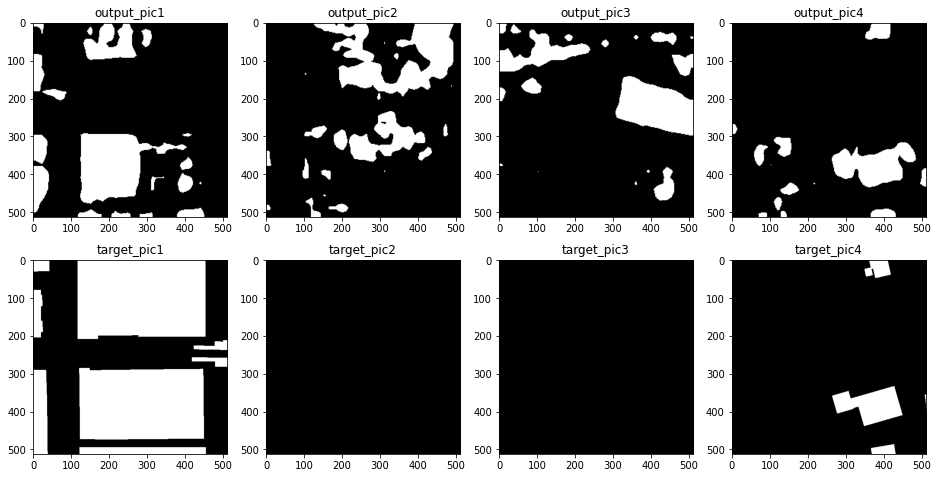

In [121]:
plt.figure(figsize=(16,8))
plt.subplot(2,4,1)
plt.imshow(output_pic[0] ,cmap='gray')
plt.title('output_pic1')
plt.subplot(2,4,2)
plt.imshow(output_pic[1] ,cmap='gray')
plt.title('output_pic2')
plt.subplot(2,4,3)
plt.imshow(output_pic[2] ,cmap='gray')
plt.title('output_pic3')
plt.subplot(2,4,4)
plt.imshow(output_pic[3] ,cmap='gray')
plt.title('output_pic4')
plt.subplot(2,4,5)
plt.imshow(target_pic[0] ,cmap='gray')
plt.title('target_pic1')
plt.subplot(2,4,6)
plt.imshow(target_pic[1] ,cmap='gray')
plt.title('target_pic2')
plt.subplot(2,4,7)
plt.imshow(target_pic[2] ,cmap='gray')
plt.title('target_pic3')
plt.subplot(2,4,8)
plt.imshow(target_pic[3] ,cmap='gray')
plt.title('target_pic4')
plt.show()

Dice loss

In [122]:
def dice(output, target):
    '''计算Dice系数'''
    smooth = 1e-6 # 避免0为除数
    intersection = (output * target).sum()
    return (2. * intersection + smooth) / (output.sum() + target.sum() + smooth)

In [142]:
for i in range(4):
    output = output_pic[i]
    target = target_pic[i]
    print('第'+str(i+1)+'张图的dice\t=  '+str(dice(output,target)))

第1张图的dice	=  0.5091781773765482
第2张图的dice	=  1.930800123533928e-11
第3张图的dice	=  2.346316283379955e-11
第4张图的dice	=  0.7218656829622047


IoU

In [134]:
def iou_score(output, target):
    '''计算IoU指标'''
    intersection = np.logical_and(target, output)
    union = np.logical_or(target, output)
    return np.sum(intersection) / np.sum(union)

In [141]:
for i in range(4):
    output = output_pic[i]
    target = target_pic[i]
    print('第'+str(i+1)+'张图的iou_score\t=  '+str(iou_score(output,target)))

第1张图的iou_score	=  0.34154193991961074
第2张图的iou_score	=  0.0
第3张图的iou_score	=  0.0
第4张图的iou_score	=  0.5647807693828332


BCE

In [151]:
import torch
import torch.nn as nn

bce = nn.BCELoss()
bce_sig = nn.BCEWithLogitsLoss()

for i in range(4):
    output = torch.from_numpy(output_pic[i].astype(np.float64))
    target = torch.from_numpy(target_pic[i].astype(np.float64))
    pre = nn.Sigmoid()(output)

    loss_bce = bce(pre, target)
    loss_bce_sig = bce_sig(output, target)
    print('第'+str(i+1)+'张图的loss_bce\t=  '+str(loss_bce.item()))
    print('第'+str(i+1)+'张图的loss_bce_sig\t=  '+str(loss_bce_sig.item()))

第1张图的loss_bce	=  0.6224266472030244
第1张图的loss_bce_sig	=  0.6224266472030244
第2张图的loss_bce	=  0.8156637002757623
第2张图的loss_bce_sig	=  0.8156637002757623
第3张图的loss_bce	=  0.7939668838015292
第3张图的loss_bce_sig	=  0.7939668838015292
第4张图的loss_bce	=  0.6969886712734124
第4张图的loss_bce_sig	=  0.6969886712734124


Focal Loss

In [156]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits	# 如果BEC带logits则损失函数在计算BECloss之前会自动计算softmax/sigmoid将其映射到[0,1]
        self.reduce = reduce

    def forward(self, inputs, targets):
        if self.logits:
            BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none') # reduce=Fasle会弹警告
        else:
            BCE_loss = F.binary_cross_entropy(inputs, targets, reduction='none') # reduce=Fasle会弹警告
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss

        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss

In [157]:
FL1 = FocalLoss(logits=False)
FL2 = FocalLoss(logits=True)

for i in range(4):
    output = torch.from_numpy(output_pic[i].astype(np.float64))
    target = torch.from_numpy(target_pic[i].astype(np.float64))
    pre = nn.Sigmoid()(output)

    f_loss_1 = FL1(pre, target)
    f_loss_2 = FL2(output, target)
    print('第'+str(i+1)+'张图的f_loss_1\t=  '+str(f_loss_1.item()))
    print('第'+str(i+1)+'张图的f_loss_2\t=  '+str(f_loss_1.item()))

第1张图的f_loss_1	=  0.1471357900120513
第1张图的f_loss_2	=  0.1471357900120513
第2张图的f_loss_1	=  0.27771906700732746
第2张图的f_loss_2	=  0.27771906700732746
第3张图的f_loss_1	=  0.2592248440082687
第3张图的f_loss_2	=  0.2592248440082687
第4张图的f_loss_1	=  0.18599851706095155
第4张图的f_loss_2	=  0.18599851706095155
